In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import os
from torch.optim import Adam
from itertools import product
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
import random
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score

# Clases

In [28]:
class Datos(Dataset): 
    def __init__(self, imagenes, etiquetas):
        """
        Convierte los datos originales a tensores de Pytorch.
        
        Parameters
        --------------
        imagenes:
            Son las imagenes del dataset.
        etiquetas:
            Son las etiquetas que se usan para la calsificación
        
        Returns
        -------------
        No devuelve nada.
        """
        self.imagenes = torch.tensor(imagenes, dtype=torch.float32)
        self.etiquetas = torch.tensor(etiquetas, dtype=torch.float32)

    def __len__(self):
        """
        Calcula la cantidad de muestras de la base.
        
        Parameters
        --------------
        No recibe parámetros.
        
        Returns
        -------------
        len(self.imagenes):
            Numero total de muestras.
        """
        return len(self.imagenes)
    
    def set_imagen(self, idx, nueva_imagen):
        """
        Reemplaza la imagen en el índice dado con una nueva imagen.
        
        Parameters
        ----------
        idx : int
            Índice de la imagen a modificar.
        nueva_imagen : torch.Tensor
            Nueva imagen que reemplazará a la existente.
        """
        self.imagenes[idx] = nueva_imagen

    def set_etiqueta(self, idx, nueva_etiqueta):
        """
        Reemplaza la etiqueta en el índice dado con una nueva etiqueta.
        
        Parameters
        ----------
        idx : int
            Índice de la etiqueta a modificar.
        nueva_etiqueta : torch.Tensor
            Nueva etiqueta que reemplazará a la existente.
        """
        self.etiquetas[idx] = nueva_etiqueta
        
    def __getitem__(self, idx):
        """
        Obtener la imagen y la etiqueta de una imagen en específico.
        
        Parameters
        --------------
        idx:
            Indice de la imagen a recuperar.
        
        Returns
        -------------
        self.imagenes[idx]:
            Imagen del indice idx.
        self.etiquetas[idx]:
            Etiqueta de la imagen en el indice idx.
        """
        return self.imagenes[idx], self.etiquetas[idx]

In [29]:
class RedMultietiqueta(nn.Module):
    def __init__(self, capas_ocultas, dim_ini=784, dim_final=14):
        """
        Red neuronal multicapa para clasificación multietiqueta.

        Parámetros
        ----------
        dim_ini : int
            Tamaño del vector de entrada (28x28=784).
        capas_ocultas : list of int
            Lista con el tamaño de cada capa oculta.
        dim_final : int
            Número de etiquetas de salida (por defecto 14 para ChestMNIST).
        """
        super(RedMultietiqueta, self).__init__()

        capas = []
        prev_dim = dim_ini

        for dim_oculta in capas_ocultas:
            capas.append(nn.Linear(prev_dim, dim_oculta))
            capas.append(nn.ReLU())
            prev_dim = dim_oculta

        capas.append(nn.Linear(prev_dim, dim_final))  # Sin sigmoid aquí

        self.net = nn.Sequential(*capas)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplana (N, 1, 28, 28) → (N, 784)
        return self.net(x)

# Funciones

In [35]:
# Entrena los modelos con auc
def entrenar(dim, capas_ocultas, train_loader, test_loader, epocas=50, lr=0.001):
    """
    Entrena el modelo de red neuronal.

    Parámetros
    ----------
    dim : int
        Dimension inicial de la red.
    capas_ocultas: list of int
        Lista con el tamaño de cada capa oculta.
    train_loader : DataLoader
        Datos de entrenamiento.
    test_loader : DataLoader
        Datos de evaluación.
    epocas : int
        Número de épocas de entrenamiento.
    lr : float
        Tasa de aprendizaje (learning rate).
    """    
    #Obtener todos las etiquetas del conjunto de entrenamiento para calcular pesos
    etiquetas = []
    for _, y_batch in train_loader:
        etiquetas.append(y_batch)
    y_train_tensor = torch.cat(etiquetas, dim=0)

    #Calcular pesos de clases: N_neg / N_pos
    n_pos = y_train_tensor.sum(dim=0)
    n_neg = y_train_tensor.shape[0] - n_pos
    peso = n_neg / (n_pos + 1e-6)
    
    #Definir modelo
    modelo = RedMultietiqueta(capas_ocultas, dim_ini = dim).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    device = next(modelo.parameters()).device
    peso_tensor = peso.to(torch.float32).to(device)
    optimizador = Adam(modelo.parameters(), lr=lr)
    criterio = nn.BCEWithLogitsLoss(pos_weight=peso_tensor)
    
    
    #Entrenar
    for epoca in range(epocas):
        modelo.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizador.zero_grad()
            salida = modelo(x_batch)
            perdida = criterio(salida, y_batch)
            perdida.backward()
            optimizador.step()
    
    #Evaluar        
    modelo.eval()
    etiquetas = []
    probabilidades = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            salida = torch.sigmoid(modelo(x_batch)).cpu().numpy()
            probabilidades.append(salida)
            etiquetas.append(y_batch.numpy())

    y_reales = np.vstack(etiquetas)
    y_pred = np.vstack(probabilidades)

    aucs = []
    for i in range(y_reales.shape[1]):
        try:
            auc = roc_auc_score(y_reales[:, i], y_pred[:, i])
            aucs.append(auc)
        except:
            aucs.append(np.nan)
    
    return np.nanmean(aucs), modelo

# Implementación

In [31]:
#Se cargan los datos 28 x 28
data = np.load("chestmnist.npz")

# Imágenes y etiquetas
X_train = data['train_images']
y_train = data['train_labels']

X_test = data['test_images']
y_test = data['test_labels']

# Agregar canal (1, H, W) pra poder usar Pytorch 
X_train = X_train[:, np.newaxis, :, :] #np.newaxis agregra una dimensión al arreglo
X_test = X_test[:, np.newaxis, :, :] 

# Convertir los datos a tensores
train_dataset = Datos(X_train, y_train)
test_dataset = Datos(X_test, y_test)

# Convertir los datos a DataLoaders para la implementación del modelo
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [36]:
# Evaluar distintos parametros
parametros = {
    "capas_ocultas": [[512, 128],
                      [64, 32, 16],
                      [256, 64, 32, 16],
                      [512, 256, 64, 32, 16],
                      [512, 256, 64, 32, 16, 4]],   
    "lr": [0.001, 0.0005, 0.0001, 0.00001]
}

mejor_auc = 0
mejor_modelo = None
mejor_config = {}

for capas, lr in product(parametros["capas_ocultas"], parametros["lr"]):
    auc, modelo_temp = entrenar(784, capas, train_loader, test_loader, lr = lr, epocas = 30)
    print(f"Capas: {capas}, LR: {lr} → Auc promedio: {auc:.4f}")
    if auc > mejor_auc:
        mejor_auc = auc
        mejor_config = {"capas_ocultas": capas, "lr": lr}
        mejor_modelo = modelo_temp
        
print("Mejor configuración:", mejor_config)
print("Mejor accuracy:", mejor_auc)

Capas: [512, 128], LR: 0.001 → Auc promedio: 0.5000
Capas: [512, 128], LR: 0.0005 → Auc promedio: 0.5000
Capas: [512, 128], LR: 0.0001 → Auc promedio: 0.5001
Capas: [512, 128], LR: 1e-05 → Auc promedio: 0.6689
Capas: [64, 32, 16], LR: 0.001 → Auc promedio: 0.5000
Capas: [64, 32, 16], LR: 0.0005 → Auc promedio: 0.5000
Capas: [64, 32, 16], LR: 0.0001 → Auc promedio: 0.6182
Capas: [64, 32, 16], LR: 1e-05 → Auc promedio: 0.6314
Capas: [256, 64, 32, 16], LR: 0.001 → Auc promedio: 0.5000
Capas: [256, 64, 32, 16], LR: 0.0005 → Auc promedio: 0.5000
Capas: [256, 64, 32, 16], LR: 0.0001 → Auc promedio: 0.6376
Capas: [256, 64, 32, 16], LR: 1e-05 → Auc promedio: 0.6732
Capas: [512, 256, 64, 32, 16], LR: 0.001 → Auc promedio: 0.5000
Capas: [512, 256, 64, 32, 16], LR: 0.0005 → Auc promedio: 0.6508
Capas: [512, 256, 64, 32, 16], LR: 0.0001 → Auc promedio: 0.5000
Capas: [512, 256, 64, 32, 16], LR: 1e-05 → Auc promedio: 0.6908
Capas: [512, 256, 64, 32, 16, 4], LR: 0.001 → Auc promedio: 0.5000
Capas: [5

In [37]:
# REENTRENAR CON EL MEJOR MODELO
capas = mejor_config["capas_ocultas"]
lr = mejor_config["lr"]

#Obtener todos las etiquetas del conjunto de entrenamiento para calcular pesos
etiquetas = []
for _, y_batch in train_loader:
    etiquetas.append(y_batch)
y_train_tensor = torch.cat(etiquetas, dim=0)

#Calcular pesos de clases: N_neg / N_pos
n_pos = y_train_tensor.sum(dim=0)
n_neg = y_train_tensor.shape[0] - n_pos
peso = n_neg / (n_pos + 1e-6)

#Definir modelo
modelo = RedMultietiqueta(capas).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(modelo.parameters()).device

peso_tensor = peso.to(torch.float32).to(device)
optimizador = Adam(modelo.parameters(), lr=lr)
criterio = nn.BCEWithLogitsLoss(pos_weight=peso_tensor)

#Entrenamos y guardamos perdidas por ecopa
historial_perdida = []
for epoca in range(150):
    modelo.train()
    perdida_total = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizador.zero_grad()
        salida = modelo(x_batch)
        perdida = criterio(salida, y_batch)
        perdida.backward()
        optimizador.step()
        perdida_total += perdida.item()
    historial_perdida.append(perdida_total / len(train_loader))

#Evaluamos el modelo
modelo.eval()
list_y_real, list_y_probs= [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        salida = modelo(x_batch)
        probs = torch.sigmoid(salida).cpu().numpy()
        list_y_real.append(y_batch.numpy())
        list_y_probs.append(probs)

y_real = np.vstack(list_y_real)
y_probs = np.vstack(list_y_probs)

In [39]:
#Suavizar los umbrales para predecir mejor
def mejor_umbral(y_real, y_probs):
    umbrales_optimos = []

    for i in range(y_real.shape[1]):
        mejores_f1 = 0
        mejor_umbral = 0.5
        for t in np.linspace(0.1, 0.9, 81):  # Umbrales de 0.1 a 0.9 con paso 0.01
            y_pred_i = (y_probs[:, i] >= t).astype(int)
            f1 = f1_score(y_real[:, i], y_pred_i, zero_division=0)
            if f1 > mejores_f1:
                mejores_f1 = f1
                mejor_umbral = t
        umbrales_optimos.append(mejor_umbral)
    
    return np.array(umbrales_optimos)


# Aplicar umbrales por clase
umbrales = mejor_umbral(y_real, y_probs)
y_pred = (y_probs >= umbrales).astype(int)

# Metricas
aucs = [roc_auc_score(y_real[:, i], y_probs[:, i]) if y_real[:,i].sum()>0 else np.nan 
        for i in range(y_real.shape[1])]
f1_micro = f1_score(y_real, y_pred, average='micro')
f1_macro = f1_score(y_real, y_pred, average='macro')
hamming = hamming_loss(y_real, y_pred)
exact_match = accuracy_score(y_real, y_pred)
precision_micro = precision_score(y_real, y_pred, average='micro')
recall_micro = recall_score(y_real, y_pred, average='micro')

# Resultados

F1-score micro: 0.2343
F1-score macro: 0.1726
Hamming Loss: 0.1535
Exact Match Ratio: 0.2832
Precisión global (micro): 0.1588
Recall global (micro): 0.4469


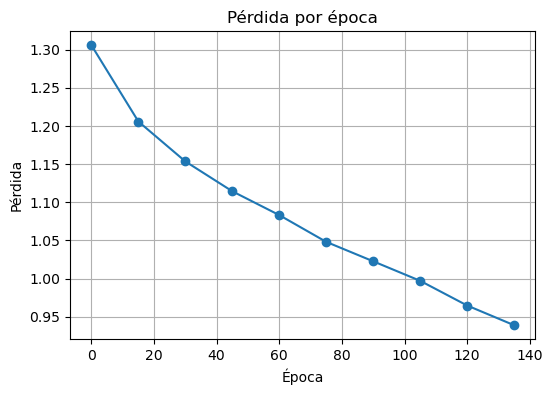

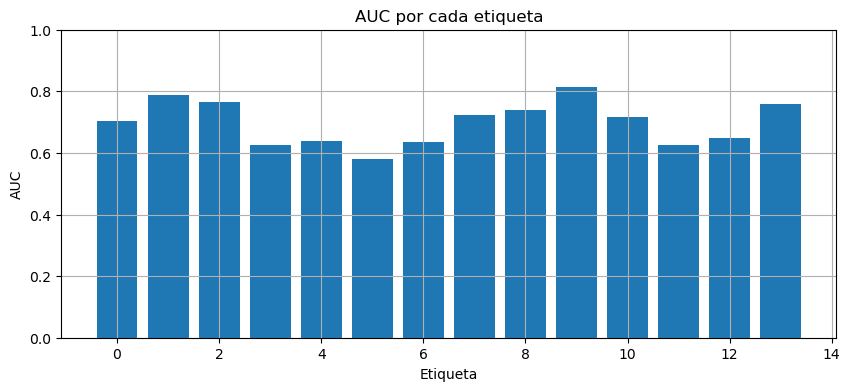

In [40]:
# Métricas generales
print(f"F1-score micro: {f1_micro:.4f}")
print(f"F1-score macro: {f1_macro:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Exact Match Ratio: {exact_match:.4f}")
print(f"Precisión global (micro): {precision_micro:.4f}")
print(f"Recall global (micro): {recall_micro:.4f}")

# Pérdida por época --ADVERTENCIA-- puede matar el kernel en jupyter
# Subconjunto de pérdida cada 20 epochs
subset = historial_perdida[::15]
# Crear los índices reales correspondientes (0, 15, 30, ...)
epochs = list(range(0, len(historial_perdida), 15))
plt.figure(figsize=(6,4))
plt.plot(epochs, subset, marker='o')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

# AUC por clase
plt.figure(figsize=(10,4))
plt.bar(range(len(aucs)), aucs)
plt.title("AUC por cada etiqueta")
plt.xlabel("Etiqueta")
plt.ylabel("AUC")
plt.ylim(0,1)
plt.grid(True)
plt.show()